# A Simple Classical Estimator

_This notebook explores the creation and use of a classical estimator in **PyTorch** to compare against **PennyLane**_.

**By:** Sebastian Zając ([website](https://sebastianzajac.pl/))<br>
**Date:** 6 April 2025<br>
**Updates:** 6 April 2025<br>
**Aims:** To develop a simple neural network classical estimator in PyTorch.<br/>
**License:** 
This project is licensed under the [Creative Commons CC-BY](https://creativecommons.org/licenses/by/4.0/)<br>
**Changes:** All changes to this code must be listed at the bottom of this notebook

In [1]:
import os
import numpy as nnp
import pandas as pd
from IPython.display import clear_output
import pennylane as qml
from pennylane import numpy as np
from pennylane import NesterovMomentumOptimizer
from torch import nn
from torch.autograd import Variable
import torch

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("warning")

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Data set :
- <a href="https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data" target="_blank">Credit Card Fraud Detection</a>:

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification. 
  
_**Data prepared according to the following objectives:**_

- *Fetch and understand data*
- *Select numeric variables only (not needed)*
- *Deal with missing values (not needed)*
- *Analyse the target*
- *Standardise predictors*
- *Reduce dimensionality using PCA*

In [2]:
print(os.listdir('../dane'))

['credit.csv']


In [3]:
CREDIT_DIR = '../dane'
CREDIT_FILE = 'credit.csv'
path = os.path.join(CREDIT_DIR, CREDIT_FILE)
df = pd.read_csv(path)

In [4]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from imblearn.under_sampling import RandomUnderSampler

In [5]:
df1 = df.copy()

#Feature Scaling
rob_scaler = RobustScaler()

df1['scaled_time'] = rob_scaler.fit_transform(df1['Time'].values.reshape(-1,1))
df1['scaled_amount'] = rob_scaler.fit_transform(df1['Amount'].values.reshape(-1,1))
df1.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df1['scaled_amount']
scaled_time = df1['scaled_time']

#scaled_amount and scaled_time are added to the starting of the dataframe
df1.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)

df1.insert(0, 'scaled_amount', scaled_amount)
df1.insert(1, 'scaled_time', scaled_time)

In [6]:
X = df1.drop(columns=['Class'])
y = df1['Class']

In [7]:
x_angle_margin = 0.1
x_angle_min = 0+x_angle_margin
x_angle_max = nnp.pi-x_angle_margin
angle_scaler = MinMaxScaler(feature_range=(x_angle_min, x_angle_max)) 
scaled = angle_scaler.fit_transform(X) 
X = pd.DataFrame(scaled, columns=X.columns)

In [9]:
# Apply random undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

df_res = pd.DataFrame(X_resampled, columns=X.columns)
df_res['Class'] = y_resampled

In [10]:
X = df_res.drop(columns=['Class'])
y = df_res['Class']

In [11]:
seed = 2025
n_data = X.shape[0]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.2, shuffle=False, random_state=seed)
print(f'Shapes: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}')

Shapes: X_train=(787, 30), X_test=(197, 30), y_train=(787,), y_test=(197,)


In [12]:
### Change the data format to tensors
import torch

X_train_tens = torch.tensor(nnp.array(X_train), dtype=torch.double)
y_train_tens = torch.tensor(nnp.array(y_train), dtype=torch.double).view(-1,1)
X_test_tens  = torch.tensor(nnp.array(X_test), dtype=torch.double)
y_test_tens  = torch.tensor(nnp.array(y_test), dtype=torch.double).view(-1,1)

In [13]:
from torch import nn

class Classic_NN(nn.Module):

    def __init__(self, in_shape, out_shape):
        super(Classic_NN, self).__init__()
        layers = self.layers(in_shape, out_shape)
        self.model = nn.Sequential(*layers)
        
    def layers(self, in_shape, out_shape):
        
        clayer_0 = torch.nn.Linear(in_shape, 64)
        clayer_1 = torch.nn.ReLU()
        clayer_2 = torch.nn.Linear(64, 32)
        clayer_3 = torch.nn.ReLU()
        clayer_4 = torch.nn.Linear(32, 18)
        clayer_5 = torch.nn.ReLU()
        clayer_6 = torch.nn.Linear(18, 8)
        clayer_7 = torch.nn.ReLU()
        clayer_8 = torch.nn.Linear(8, out_shape)
        clayer_9 = torch.nn.Sigmoid()
        
        layers = [clayer_0, clayer_1, clayer_2, clayer_3, clayer_4,
                  clayer_5, clayer_6, clayer_7, clayer_8, clayer_9]
        return layers

    def forward(self, x):
        x = self.model(x)
        return x

In [14]:
### Performance measures

### A simple MSE cost function
def square_mse(labels, predictions):
    sq_diffs = torch.tensor([(l - p)**2 for l, p in zip(labels, predictions)])
    return sq_diffs.mean().item()

### Calculates accuracy from expval predictions
def accuracy(labels, predictions, prec=1e-5):
    acc = sum(abs(l - p) < prec for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc.item()

### Counts the number of pytorch model parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
X_train_tens.shape

torch.Size([787, 30])

In [16]:
epochs = 400
test = Classic_NN(in_shape=X_train_tens.shape[1], out_shape=1).double()

print(f'\nCM weights: {count_params(test)}, Epochs: {epochs}')
#print(f'\nTest results: {test(X_train_tens)}\n')
test.eval()


CM weights: 4819, Epochs: 400


Classic_NN(
  (model): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
    (5): ReLU()
    (6): Linear(in_features=18, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [17]:
torch_device = "cpu"

In [18]:
import time
import copy

def train_model(model, X, y, cost_fun, acc_fun, optimizer, epochs, 
                    log_interv=100, prompt_fract=0.1, acc_prec=0.5, start_time=0):
    
    history = []
    acc_hist = []
    opt_params = {}
    hist_params = []
    min_epoch = 0
    min_cost = 1000
    max_acc = -1000
    if start_time == 0: start_time = time.time()
    
    model.train()
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        output = model(X)
        cost = cost_fun(output, y)
        acc = acc_fun(output, y, prec=acc_prec)
        cost.backward()
        optimizer.step()

        curr_cost = cost.item()
        curr_acc = acc
        if curr_cost < min_cost: 
            min_cost = curr_cost
            min_epoch = epoch
            opt_params = copy.deepcopy(model.state_dict())

        if curr_acc > max_acc:
            max_acc = curr_acc

        if epoch % log_interv == 0:
            history.append(curr_cost)
            acc_hist.append(curr_acc)
            hist_params.append(copy.deepcopy(model.state_dict()))

        elapsed = time.time() - start_time
        if (prompt_fract == 0) or (epoch % int(prompt_fract*epochs) == 0):
            print(f'{epoch: 5d} '+ \
                  f'({elapsed:06.0f} sec): '+ \
                  f'Cost {curr_cost:6.4g}   '+ \
                  f'Acc {curr_acc:6.4g}')
            
    return history, acc_hist, opt_params, hist_params, (min_epoch, min_cost)

In [20]:
### Ensure repeatability
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

log_interv = 1   # History to be saved only once every interv or epochs
acc_prec = 0.5   # Precision of accuracy calculation

### Create a model
q_auto = Classic_NN(in_shape=X_train_tens.shape[1], out_shape=1).double().to(torch_device)

### Loss and optimiser
cost_fun = torch.nn.BCELoss()

# opt = optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)
opt = torch.optim.Adam(q_auto.parameters())
#opt = torch.optim.NAdam(q_auto.parameters(), lr=0.01)

### Train the model
print()

prompt_fract = 0.1
start_time = time.time()
train_mse_hist, train_acc_hist, opt_params, hist_params, opt_point = \
    train_model(q_auto, X_train_tens, y_train_tens, cost_fun, accuracy, opt, epochs, 
                log_interv=log_interv, prompt_fract=prompt_fract, acc_prec=acc_prec)
elapsed = time.time() - start_time

### Print the training summary
train_min_mse = np.min(train_mse_hist)
train_min_mse_iter = np.argmin(train_mse_hist)
train_max_acc = np.max(train_acc_hist)
train_max_acc_iter = np.argmax(train_acc_hist)

time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed))
print(f'\nTraining completed: epochs={epochs} '+\
      f'in {elapsed:0.0f}sec ({time_str})\n\t'+
      f'min BCE = {np.round(train_min_mse, 5):05.4f} @ {train_min_mse_iter:04d}, '+
      f'max ACC = {np.round(train_max_acc, 5):05.4f} @ {train_max_acc_iter:04d}')


    0 (000000 sec): Cost 0.6747   Acc 0.6252
   40 (000000 sec): Cost 0.5714   Acc 0.6252
   80 (000000 sec): Cost 0.2866   Acc 0.9212
  120 (000001 sec): Cost 0.1548   Acc 0.9377
  160 (000001 sec): Cost 0.1294   Acc 0.9466
  200 (000001 sec): Cost 0.1232   Acc 0.9479
  240 (000001 sec): Cost   0.12   Acc 0.9504
  280 (000002 sec): Cost 0.1177   Acc 0.9543
  320 (000002 sec): Cost 0.1161   Acc 0.9568
  360 (000002 sec): Cost 0.1141   Acc 0.9555

Training completed: epochs=400 in 2sec (00:00:02)
	min BCE = 0.1128 @ 0398, max ACC = 0.9568 @ 0318


In [21]:
### Accumulate test scores
test_mse_hist = []
test_acc_hist = []

### Initialise testing loss and accuracy
test_min_mse = 1000
test_min_mse_iter = -1
test_max_acc = 0
test_max_acc_iter = -1

### Calculate testing loss and accuracy
for iter in range(len(hist_params)):
    q_auto.load_state_dict(hist_params[iter])
    test_pred = q_auto(X_test_tens)
    curr_acc = accuracy(y_test_tens, test_pred, prec=acc_prec)
    curr_cost = square_mse(y_test_tens, test_pred)
    test_acc_hist.append(curr_acc)
    test_mse_hist.append(curr_cost)
    if curr_acc > test_max_acc:
        test_max_acc = curr_acc
        test_max_acc_iter = iter
    if curr_cost < test_min_mse:
        test_min_mse = curr_cost
        test_min_mse_iter = iter

### Run summary
time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed))
print('\nCompleted calculation of testing scores\n\nSummary of model training run\n\n\t'+
      f'params = {count_params(q_auto)}, '+
      f'epochs = {epochs}, '+
      f'time = {elapsed:0.0f}sec ({time_str})\n\t'+
      f'training: BCE = {np.round(train_min_mse, 5):05.4f} @ {train_min_mse_iter:04d}, '+
      f'ACC = {np.round(train_max_acc, 5):05.4f} @ {train_max_acc_iter:04d}\n\t'+
      f'testing:  BCE = {np.round(test_min_mse, 5):05.4f} @ {test_min_mse_iter:04d}, '+
      f'ACC = {np.round(test_max_acc, 5):05.4f} @ {test_max_acc_iter:04d}\n\t'+
      '\n'
     )


Completed calculation of testing scores

Summary of model training run

	params = 4819, epochs = 400, time = 2sec (00:00:02)
	training: BCE = 0.1128 @ 0398, ACC = 0.9568 @ 0318
	testing:  BCE = 0.1113 @ 0355, ACC = 0.8680 @ 0260
	



In [22]:
### Import utilities
from utilities import multi_plot_hist, multi_plot_series, draw_circuit

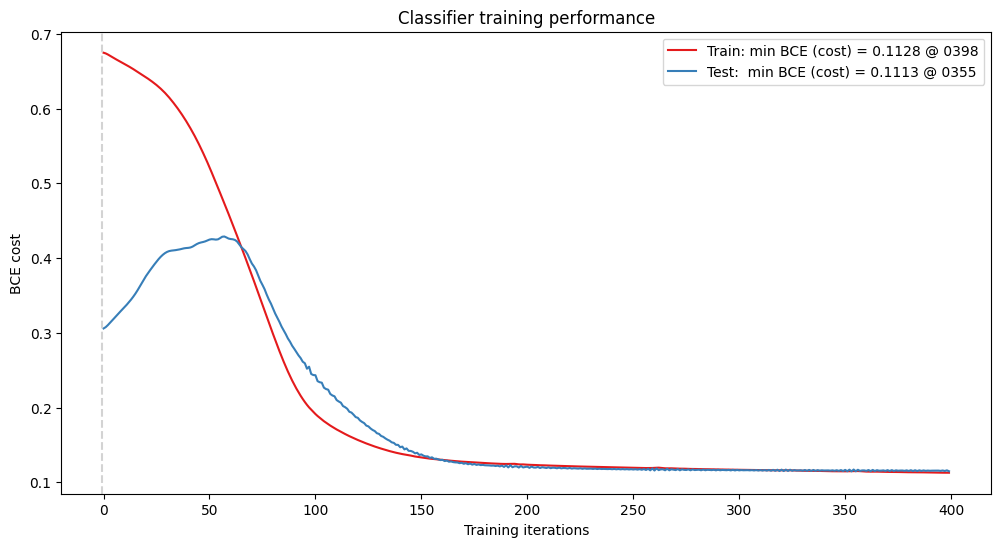

In [24]:
train_label = f'Train: min BCE (cost) = {round(train_min_mse, 5):05.4f} @ {train_min_mse_iter:04d}'
test_label =  f'Test:  min BCE (cost) = {round(test_min_mse, 5):05.4f} @ {test_min_mse_iter:04d}'
multi_plot_series(
    [train_mse_hist, test_mse_hist], X_list=[0, 0], labels=[train_label, test_label], 
    lines=['solid', 'solid'], # colors=None, markers=None, marker_colors=None,
    rcParams=(12, 6), xlabel='Training iterations', ylabel='BCE cost',
    legend_cols=1, smooth_weight=0.6, title='Classifier training performance')